In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.io as sio

from PIL import Image
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from scipy.io import loadmat
from tqdm import tqdm

import cv2

In [ ]:
blended_img = weighted_ensemble(Gaussian(img),Median(img))
kmeans_img = canny_edge(k-means(blended_img))
ensemble_img = weighted_ensemble(blended_img, kmeans_img)
threshold(ensemble_img, threshold_value)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
data_dir = "/content/gdrive/MyDrive/CV/termProject"

# Checking if our specified directory exists
os.path.exists(data_dir)

True

# Train data 불러오기

In [ ]:
# train data 불러오는 class

class BoundaryDataset(object):
    """
    Project boundary dataset wrapper

    Given the path to the root of the dataset, this class provides
    methods for loading images and ground truths.

    Attributes:

    root_dir - the root path of the dataset
    data_path - the path of the data directory within the root
    sample_names - a list of names of images
    """
    def __init__(self, root_dir='.', split='train'):
        """
        Constructor

        :param root_dir: the path to the root of the custom dataset
        :param split: 'train' or 'test'
        """
        self.root_dir = root_dir
        self.data_path = os.path.join(root_dir, split)
        self.sample_names = self._sample_names(self.data_path)

    def __len__(self):
        """
        Get the number of samples in the dataset
        :return: the number of samples
        """
        return len(self.sample_names)

    @staticmethod
    def _sample_names(directory):
        names = []
        files = os.listdir(directory)
        for fn in files:
            name, ext = os.path.splitext(fn)
            if ext.lower() == '.jpg':
                names.append(name)
        return names

    def read_image(self, name):
        """
        Load the image identified by the sample name
        :param name: the sample name
        :return: a (H,W,3) array containing the image
        """
        path = os.path.join(self.data_path, f"{name}.jpg")
        return imread(path)

    def load_boundaries(self, name):
        """
        Load the boundaries identified by the sample name
        :param name: the sample name
        :return: a list of (H,W) arrays, each of which contains a boundary ground truth
        """
        boundary_path = os.path.join(self.data_path, f"{name}.npy")
        if os.path.exists(boundary_path):
            boundaries = np.load(boundary_path, allow_pickle=True)
            return list(boundaries)
        return []

In [ ]:
num_images = 10
split = 'train'

# Load the dataset using BoundaryDataset class
dataset = BoundaryDataset(data_dir, split=split)

print(f"Data size: {len(dataset)}")

Data size: 200


# ground truth 함께 확인

Processing image: train/147062


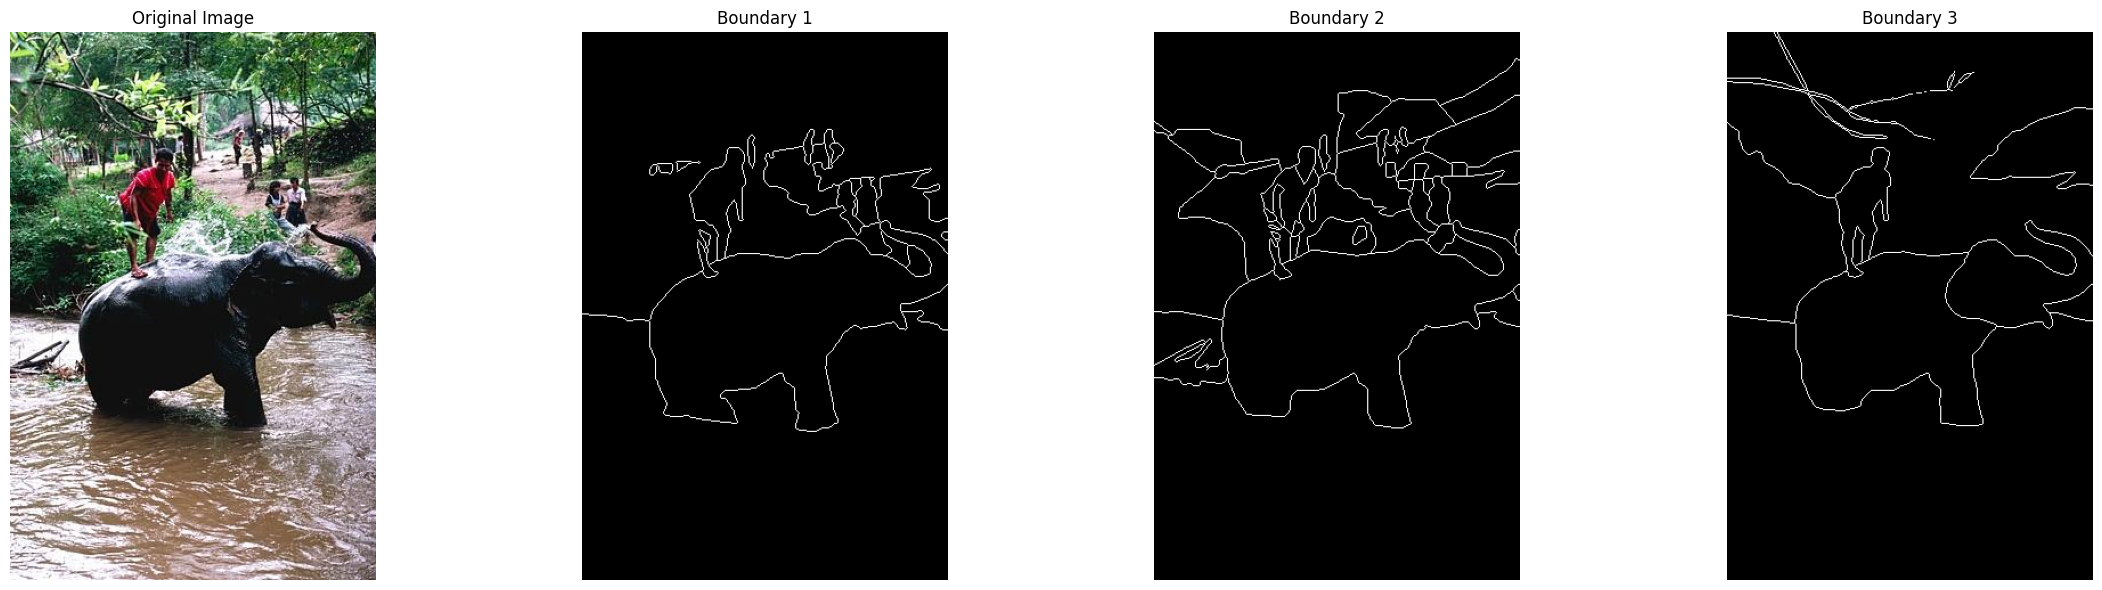

In [ ]:
# 교수님이 주신 코드

selected_sample_name = dataset.sample_names[9]
print(f"Processing image: {split}/{selected_sample_name}")
image = dataset.read_image(selected_sample_name)
boundaries = dataset.load_boundaries(selected_sample_name)

fig, ax = plt.subplots(1, len(boundaries) + 1, figsize=(6 * (len(boundaries) + 1), 6))

ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

for i in range(len(boundaries)):
    ax[i + 1].imshow(boundaries[i], cmap='gray')
    ax[i + 1].set_title(f"Boundary {i + 1}")
    ax[i + 1].axis("off")

plt.tight_layout()
plt.show()


# Canny Edge detector

In [ ]:
selected_sample_name = dataset.sample_names[33]
print(f"Processing image: {split}/{selected_sample_name}")
image = dataset.read_image(selected_sample_name)
#image = np.array(image, dtype=np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Processing image: train/189011


In [ ]:
# 블러링
blur9_img  = cv2.blur(image, (9, 9))
blur99_img = cv2.blur(image, (99, 99))
gblur_img  = cv2.GaussianBlur(image, (33, 33), sigmaX = 0, sigmaY = 0)

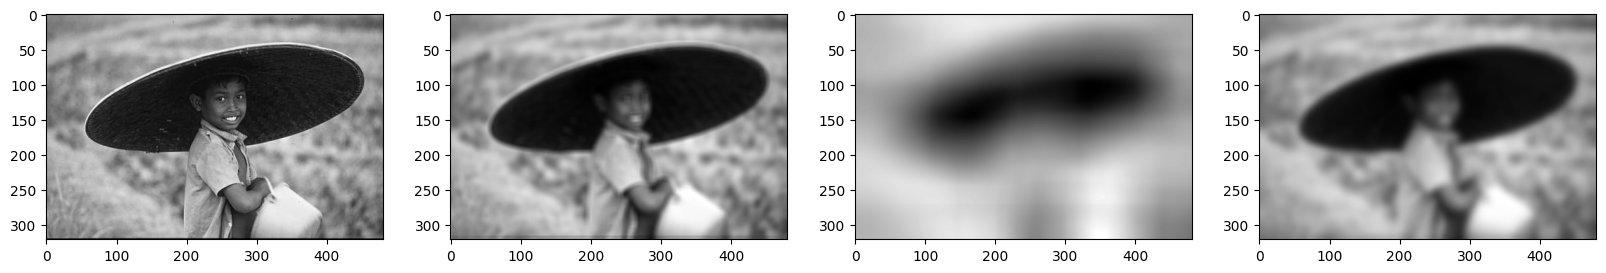

In [ ]:
fig, subs = plt.subplots(ncols = 4, figsize = (20, 5))
for sub, img in zip(subs.flatten(), [image, blur9_img, blur99_img, gblur_img]): sub.imshow(img, cmap='gray')
plt.show()

## adaptive_threshold 적용
1. mean
2. gaussian

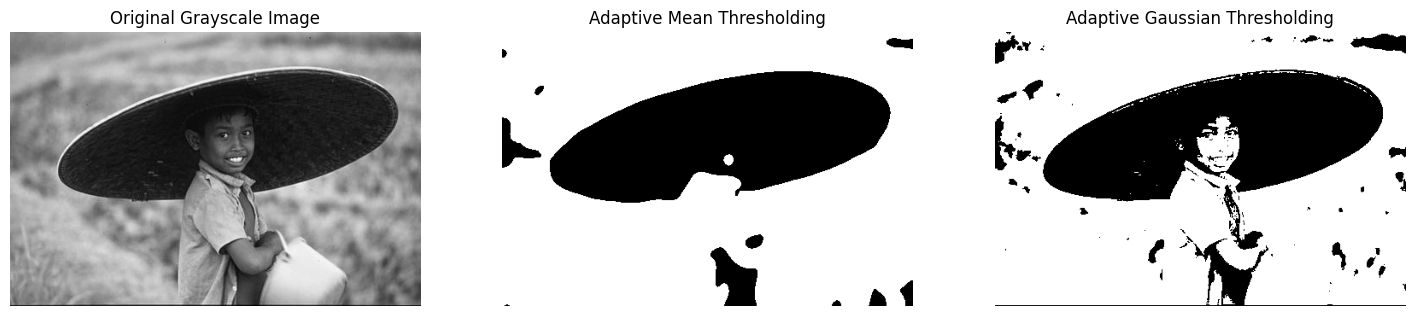

In [ ]:
# Apply Adaptive Mean Thresholding
adaptive_thresh_mean = cv2.adaptiveThreshold(
    gblur_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 401, 17)

# Apply Adaptive Gaussian Thresholding
adaptive_thresh_gaussian = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 401, 17)

# Display the original and adaptive thresholded images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Grayscale Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adaptive Mean Thresholding')
plt.imshow(adaptive_thresh_mean, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Adaptive Gaussian Thresholding')
plt.imshow(adaptive_thresh_gaussian, cmap='gray')
plt.axis('off')
plt.show()

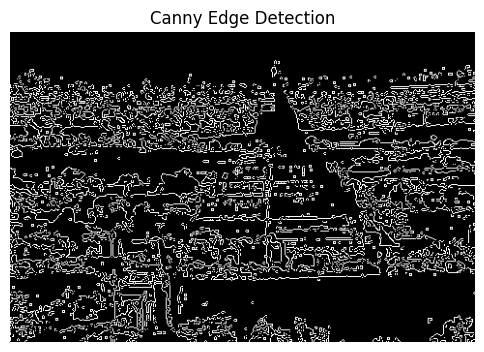

In [ ]:
# Apply Canny Edge Detection
canny_edge = cv2.Canny(adaptive_thresh_mean, threshold1=255, threshold2=255)

# Display the Canny edge detection result
plt.figure(figsize=(6, 6))
plt.title('Canny Edge Detection')
plt.imshow(canny_edge, cmap='gray')
plt.axis('off')
plt.show()

# **Contour Detection**

contours : 윤곽선의 지점

hierarchy : contours에 해당하는 속성들

In [ ]:
selected_sample_name = dataset.sample_names[9]
print(f"Processing image: {split}/{selected_sample_name}")
image = dataset.read_image(selected_sample_name)
#image = np.array(image, dtype=np.uint8)
image_copy = image.copy()

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Processing image: train/147062


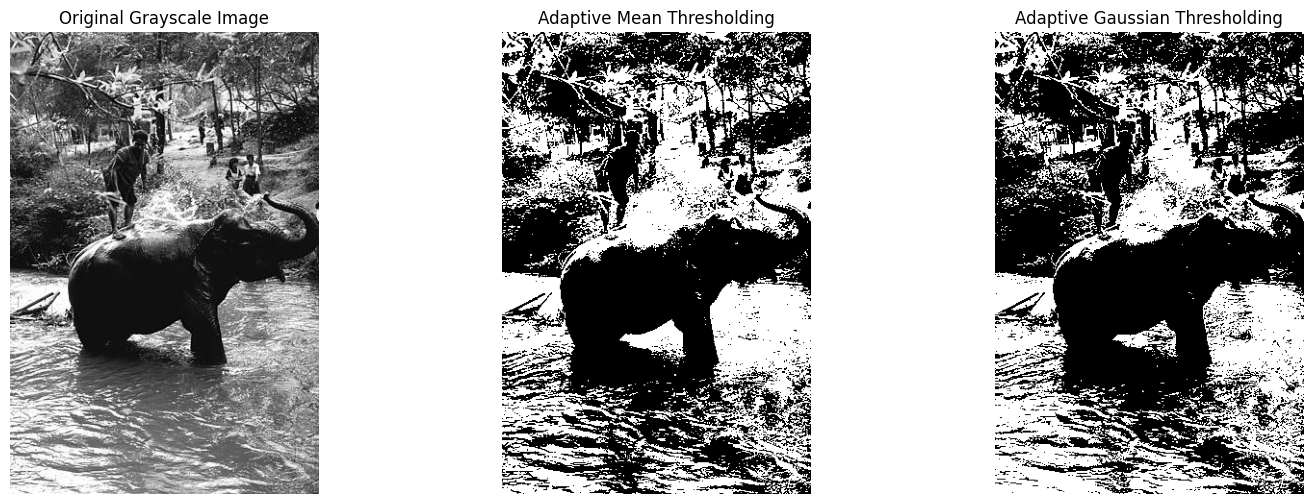

In [ ]:
# Apply Adaptive Mean Thresholding (이 적용된 이미지임.)
adaptive_thresh_mean = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 201, 1)

# Apply Adaptive Gaussian Thresholding
adaptive_thresh_gaussian = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 4001, 17)

# Display the original and adaptive thresholded images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title('Original Grayscale Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adaptive Mean Thresholding')
plt.imshow(adaptive_thresh_mean, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Adaptive Gaussian Thresholding')
plt.imshow(adaptive_thresh_gaussian, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
black = np.zeros(image.shape, np.uint8)
contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)



array([[255, 255, 255, ..., 255, 255, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       ...,
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
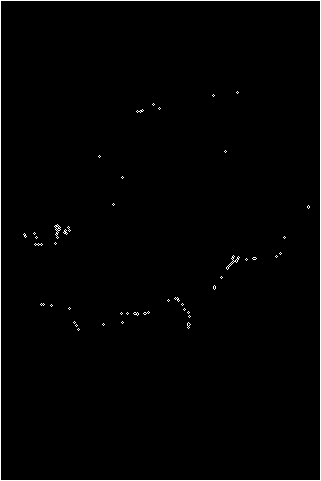

In [ ]:
cv2.drawContours(black, contours, -1, (255,0,255), 1)

(-0.5, 320.5, 480.5, -0.5)

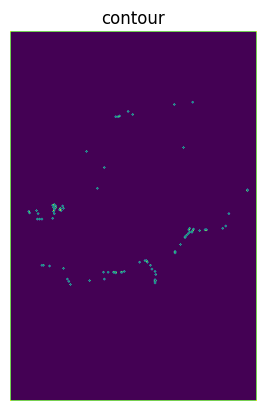

In [ ]:
plt.title('contour')
plt.imshow(black)
plt.axis('off')